In [1]:
!pip install evaluate rouge rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=49201620e0a2ba8e70ac23cf600ba901ab0ed0d8de1b9b496ac6ee7a582c2f28
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
from kaggle_secrets import UserSecretsClient

# Retrieve the Hugging Face API token from Kaggle secrets
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

In [3]:
import torch,nltk,spacy,string,transformers,json,evaluate,warnings
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")

In [4]:
# nltk.download('punkt')          # Tokenizer models
# nltk.download('wordnet')        # WordNet lexical database
# nltk.download('omw-1.4')        # Open Multilingual WordNet
# nltk.download('averaged_perceptron_tagger')  # POS tagger
# nltk.download('stopwords')      # Common stop words
# nltk.download('vader_lexicon')  # Sentiment analysis lexicon

In [5]:
model_name = "aayeshanakarmi/T5-QG-finetuned-squad"

TOKENIZER = T5Tokenizer.from_pretrained(model_name, use_auth_token=hf_token)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load the model from the Hugging Face model hub
MODEL = T5ForConditionalGeneration.from_pretrained(model_name, use_auth_token=hf_token, return_dict=True)

# MODEL = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict=True)
MODEL.to(DEVICE)
OPTIMIZER = Adam(MODEL.parameters(), lr=0.00001)
Q_LEN = 256   # Question Length
T_LEN = 32    # Target Length
BATCH_SIZE = 4
EPOCHS = 5
OUTPUT_DIR = '/kaggle/tmp/'
OUTPUT_MODEL_NAME = 'AQG-finetuned-squad-lite'




tokenizer_config.json:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [6]:
# Loading the data

with open('/kaggle/input/squad-20/train-v2.0.json') as f:
    data = json.load(f)

In [7]:
# Extracting context, question, and answers from the dataset

def prepare_data(data):
    articles = []
    
    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            for qa in paragraph["qas"]:
                question = qa["question"]

                if not qa["is_impossible"]:
                    answer = qa["answers"][0]["text"]
                
                inputs = {"context": paragraph["context"], "question": question, "answer": answer}

            
                articles.append(inputs)

    return articles

In [8]:
data = prepare_data(data)

# Create a Dataframe
data = pd.DataFrame(data)
data

,context,question,answer
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas"
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s
...,...,...,...
130314,"The term ""matter"" is used throughout physics i...",Physics has broadly agreed on the definition o...,Kathmandu Metropolitan City
130315,"The term ""matter"" is used throughout physics i...",Who coined the term partonic matter?,Kathmandu Metropolitan City
130316,"The term ""matter"" is used throughout physics i...",What is another name for anti-matter?,Kathmandu Metropolitan City
130317,"The term ""matter"" is used throughout physics i...",Matter usually does not need to be used in con...,Kathmandu Metropolitan City


In [9]:
# data = data.sample(n=1000, random_state=42)
# data = data.reset_index(drop=True)
data, test_data = train_test_split(data, test_size=0.1, random_state=42)

data = data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print(f"Data size: {len(data)}")
print(f"Testing data size: {len(test_data)}")

Data size: 117287
Testing data size: 13032


In [10]:
class QA_Dataset(Dataset):
    def __init__(self, tokenizer, dataframe, q_len, t_len):
        self.tokenizer = tokenizer
        self.q_len = q_len
        self.t_len = t_len
        self.data = dataframe
        self.questions = self.data["question"]
        self.context = self.data["context"]
        self.answer = self.data['answer']
        
    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.context[idx]
        answer = self.answer[idx]
        
        # Tokenizing the question and context pair with truncation
        question_tokenized = self.tokenizer(question, context, max_length=self.q_len, 
                                            padding="max_length", truncation=True, 
                                            add_special_tokens=True)
        
        # Tokenizing the answer with truncation
        answer_tokenized = self.tokenizer(answer, max_length=self.t_len, 
                                          padding="max_length", truncation=True, 
                                          add_special_tokens=True)
        
        # Preparing the labels
        labels = torch.tensor(answer_tokenized["input_ids"], dtype=torch.long)
        labels[labels == 0] = -100  # Masking padding tokens in the labels
        
        return {
            "input_ids": torch.tensor(question_tokenized["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(question_tokenized["attention_mask"], dtype=torch.long),
            "labels": labels,
            "decoder_attention_mask": torch.tensor(answer_tokenized["attention_mask"], dtype=torch.long)
        }


In [11]:
# Dataloader
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = QA_Dataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

In [12]:
print(len(train_loader),len(val_loader))

23458 5865


In [13]:
import logging
logging.disable(logging.WARNING)

# Lists to store loss values for each epoch
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Training phase
    MODEL.train()
    train_loss = 0
    train_batch_count = 0
    
    # Loop through training data
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)

        # Forward pass
        outputs = MODEL(
                          input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels,
                          decoder_attention_mask=decoder_attention_mask
                        )

        # Backpropagation
        OPTIMIZER.zero_grad()
        outputs.loss.backward()
        OPTIMIZER.step()

        # Accumulate training loss
        train_loss += outputs.loss.item()
        train_batch_count += 1

    # Compute average training loss for the epoch
    avg_train_loss = train_loss / train_batch_count
    train_losses.append(avg_train_loss)

    # Validation phase
    MODEL.eval()
    val_loss = 0
    val_batch_count = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{EPOCHS}"):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)

            # Forward pass
            outputs = MODEL(
                              input_ids=input_ids,
                              attention_mask=attention_mask,
                              labels=labels,
                              decoder_attention_mask=decoder_attention_mask
                            )

            # Accumulate validation loss
            val_loss += outputs.loss.item()
            val_batch_count += 1

    # Compute average validation loss for the epoch
    avg_val_loss = val_loss / val_batch_count
    val_losses.append(avg_val_loss)

    # Print out losses after each epoch (not each batch)
    print(f"Epoch {epoch+1}/{EPOCHS} -> Train loss: {avg_train_loss:.4f}\tValidation loss: {avg_val_loss:.4f}")


Validation Epoch 1/5: 100%|██████████| 5865/5865 [02:38<00:00, 37.08it/s]


Epoch 1/5 -> Train loss: 1.1240	Validation loss: 0.8418


Validation Epoch 2/5: 100%|██████████| 5865/5865 [02:38<00:00, 36.98it/s]


Epoch 2/5 -> Train loss: 0.9276	Validation loss: 0.7574


Validation Epoch 3/5: 100%|██████████| 5865/5865 [02:38<00:00, 37.09it/s]


Epoch 3/5 -> Train loss: 0.8736	Validation loss: 0.7089


Validation Epoch 4/5: 100%|██████████| 5865/5865 [02:38<00:00, 37.05it/s]


Epoch 4/5 -> Train loss: 0.8304	Validation loss: 0.6655


Training Epoch 5/5:  34%|███▎      | 7864/23458 [11:55<23:26, 11.09it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 5/5: 100%|██████████| 5865/5865 [02:38<00:00, 36.98it/s]

Epoch 5/5 -> Train loss: 0.7953	Validation loss: 0.6239


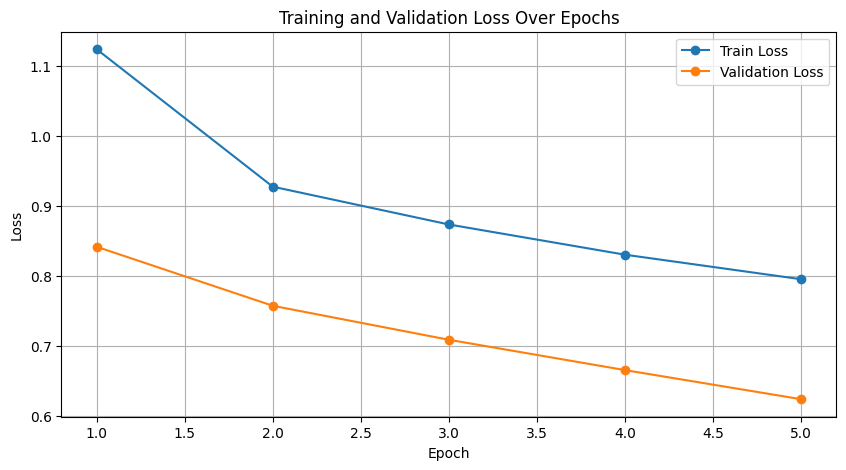

In [14]:
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
MODEL.save_pretrained(f'{OUTPUT_DIR}{OUTPUT_MODEL_NAME}')
TOKENIZER.save_pretrained(f'{OUTPUT_DIR}{OUTPUT_MODEL_NAME}')

('/kaggle/tmp/AQG-finetuned-squad-lite/tokenizer_config.json',
 '/kaggle/tmp/AQG-finetuned-squad-lite/special_tokens_map.json',
 '/kaggle/tmp/AQG-finetuned-squad-lite/spiece.model',
 '/kaggle/tmp/AQG-finetuned-squad-lite/added_tokens.json')

In [21]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

In [24]:
from huggingface_hub import login

# Replace 'your_token' with your actual Hugging Face token
login(token=hf_token)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [25]:
# Save the fine-tuned model and tokenizer locally
MODEL.save_pretrained("T5-QuestionAnswering-squad-10")
TOKENIZER.save_pretrained("T5-QuestionAnswering-squad-10")

('T5-QuestionAnswering-squad-10/tokenizer_config.json',
 'T5-QuestionAnswering-squad-10/special_tokens_map.json',
 'T5-QuestionAnswering-squad-10/spiece.model',
 'T5-QuestionAnswering-squad-10/added_tokens.json')

In [27]:
# Replace 'your_token' with your actual Hugging Face token
MODEL.push_to_hub("T5-QuestionAnswering-squad-10", use_auth_token=hf_token, use_temp_dir=False)
TOKENIZER.push_to_hub("T5-QuestionAnswering-squad-10", use_auth_token=hf_token, use_temp_dir=False)

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aayeshanakarmi/T5-QuestionAnswering-squad-10/commit/8523ba8fdd34c34665cb3753aa3a2ccff4ad700c', commit_message='Upload tokenizer', commit_description='', oid='8523ba8fdd34c34665cb3753aa3a2ccff4ad700c', pr_url=None, pr_revision=None, pr_num=None)